In [50]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter


def import_data(file):
    '''Import trajectory data which is used for further analysis'''
    df = pd.read_csv(file)
    # print(df)

    frame = df['frame']
    obj_id = df['obj_id']
    x = df['x']
    y = df['y']
    
    return frame, x, y

def calc_velocity(frame, x, y):
    '''Calculating velocity at each intervals'''
    N = len(frame)       # total number of frames
    dt = t_tot/N         # interval of each frame
    vel = []             # list to store velocity
#     a = []
    t = 0.0

    for i in range(1,N-1):
        dx = x[i] - x[i-1]
        dy = y[i] - y[i-1]

        dr = np.sqrt(dx**2 + dy**2) # measuring displacement at each frame
        v = dr/dt                   # calculating velocity at each interval
        vel.append(v)               # appending velocities to a list at each frame
#         acc = (x[i+1] - 2*x[i] + x[i+1])/(dt*dt)
#         a.append(acc)
#     plt.plot(vel)
#     plt.plot(a)
    
    return vel

    
def kalman_filter(data):
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=1e-6, observation_covariance=0.05)
    
    filtered_state_means, _ = kf.filter(data)
    
    kf = kf.em(data, n_iter=10)  # Estimate optimal parameters from data
    return filtered_state_means


def calc_angle(smooth_x, smooth_y):
    N = len(smooth_x)
    dt = t_tot/N
    angle = []
    for i in range(1,N):
        vx = (smooth_x[i]-smooth_x[i-1])/dt
        vy = (smooth_y[i]-smooth_y[i-1])/dt
        mod_v = np.sqrt(vx*vx + vy*vy)
        vx_cap = vx/mod_v
        vy_cap = vy/mod_v
        # theta = math.asin(vx_cap)
        theta = np.arctan2(vy, vx)
        angle.append(theta*180/np.pi)

    return angle


if __name__ == "__main__":
    
    file1 = "/home/debasish/Documents/YOLOv8/outputs/orientation/run1/image003_positions.csv"
    t_tot = 30.4
    frame, x, y = import_data(file)
    N = len(frame)
    dt = t_tot/N
    vel = calc_velocity(frame, x, y)
    smooth_x = kalman_filter(x)
    smooth_y = kalman_filter(y)
    smooth_v = kalman_filter(vel)
    
    angle = calc_angle(smooth_x, smooth_y)

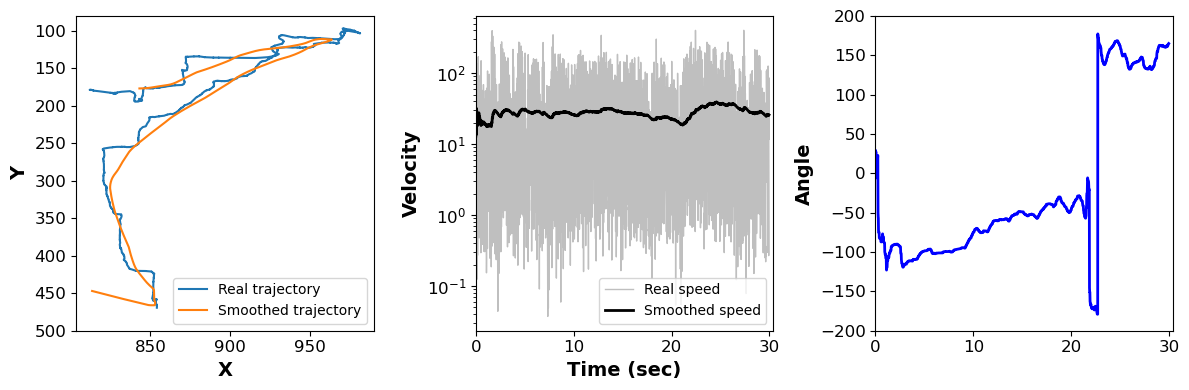

In [63]:
T = np.linspace(0,t_tot,N-1)
fig, ax = plt.subplots(1, 3,figsize=(12,4))
fig.align_labels()

ax[0].plot(x,y, label="Real trajectory")
ax[0].plot(smooth_x, smooth_y, label="Smoothed trajectory")
ax[0].set_xlabel("X", fontsize=14, weight='bold')
ax[0].set_ylabel("Y", fontsize=14, weight='bold')
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylim(500, 80)
ax[0].legend()

ax[1].plot(T[:3000], vel[:3000], color='grey', linewidth=1, alpha=0.5, label="Real speed")
ax[1].plot(T[:3000], smooth_v[:3000], color='black', linewidth=2, label="Smoothed speed")
ax[1].set_xlabel("Time (sec)", fontsize=14, weight='bold')
ax[1].set_ylabel("Velocity", fontsize=14, weight='bold')
ax[1].set_yscale("log")
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_xlim(0, t_tot)
ax[1].legend()

ax[2].plot(T[:3000], angle[:3000], color='blue', linewidth=2)
ax[2].set_ylabel("Angle", fontsize=14, weight='bold')
ax[2].tick_params(axis='both', labelsize=12)
ax[2].set_xlim(0, t_tot)
ax[2].set_ylim(-200, 200)
T = np.linspace(0,t_tot,N-2)

plt.tight_layout()
plt.show()

# plt.savefig(f"./images/{file}.png")